# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by Francesco Colombi

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [4]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [5]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [6]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9974 / 11441 MB available


In [ ]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols){
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];
}

//NOTE: we need to implement the function matrixVectorKernel : c = A*b
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols){
    //NOTE: write for loop that computes the vector-vector inner product
    // of row j of A by the vector b, and store the results in c[j]
    
    // newton formulation : c(j) = A(j,i)*b(i,1)
    
    // i index is always zero !
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    float sum = 0.0f;
    
    for (int i=0; i<a_cols; ++i){
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
        
        //c[j] += A[k]+ * b[i];
        // it is slower because it write and read c[j] back and forth from the global GPU memory (slower than internal memory of the register)
    }
    
    c[j] = sum;
    //c[j] = j; //DEBUG: compute one element of c for each thread
}

"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [ ]:
testing_variable = np.empty((5,2)).astype(np.float32)
plt.figure()
plt.imshow(testing_variable)
plt.colorbar()

testing_variable = np.zeros((5,2), dtype=np.float32)
plt.figure()
plt.imshow(testing_variable)
plt.colorbar()

testing_variable = np.ones((5,2), dtype=np.float32)
plt.figure()
plt.imshow(testing_variable)
plt.colorbar()

In [ ]:
#Size of our test
test_size = (4,3)

#Create test input / output data
A = np.random.random(test_size).astype(np.float32)
b = np.random.random((test_size[1],1)).astype(np.float32)
c = np.empty((test_size[0],1)).astype(np.float32)

fig = plt.figure();
plt.subplot(1,3,1)
plt.imshow(A)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)


In [ ]:
print(A.shape)
print(b.shape)
print(c.shape)

In [ ]:
#Upload data to the device
# NOTE: we need to make sure that a=(a_rows, a_columns)
#   and b=(a_colums, 1) (col vector)
#       c=(a_rows, 1)
A_g = GPUArray(A.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
A_g.set(A)
b_g.set(b)

In [18]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [19]:
# a.shape = [rows, colums] => [y, x]
# NOTE: we need to change this so that the grid*block is x = 1, y = number of rows of A
domain_size = (A.shape[1], A.shape[0]) # now domain size is [x, y]
block_size = (1,1,1) # this needs to be [x, y, z]
grid_size = (1, c.shape[0], 1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (3, 4)
Block size is (1, 1, 1)
Grid size is (1, 4, 1)


In [21]:
#Execute program on device
kernel(c_g, A_g, b_g, np.int32(A.shape[0]), np.int32(A.shape[1]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.5869916 ],
       [0.20666306],
       [0.6571291 ],
       [0.08602986]], dtype=float32)

In [24]:
#Compute reference using Numpy
c_ref = np.dot(A,b)

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.5869916 ]
 [0.20666306]
 [0.6571291 ]
 [0.08602986]]
Ref =  [[0.5869916 ]
 [0.20666306]
 [0.6571291 ]
 [0.08602986]]
Sad =  0.0


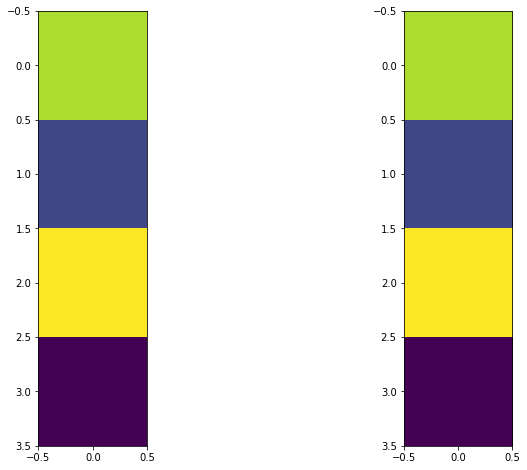

In [25]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)